In [1]:
from util.backtest import *
from util.factor_util import *
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
from tqdm import tqdm
import warnings
import requests
from bs4 import BeautifulSoup
import glob

warnings.filterwarnings("ignore")

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False

In [3]:
url = 'https://api.tardis.dev/v1/exchanges/binance-futures'
result = requests.get(url).json()
result['availableSymbols']
perpetual_symbols = [sym['id']for sym in result['availableSymbols'] if 'usdt' in sym['id'] and sym['type']=='perpetual']
perpetual_symbols[:5]


['btcusdt', 'ethusdt', 'bchusdt', 'xrpusdt', 'eosusdt']

In [4]:
cmc_info  = {}
with open('./data/Crytpo_cmc_info.json','r') as f:
    cmc_info = json.loads(f.read())

cmc_info['btt']['slug']

'bittorrent-new'

In [5]:
ls = []
date_range = [
    (1577808000,1609430399),
    (1609430400,1640966399),
    (1640966400,1672502399),
    (1672502400,1704038399),
]
for key in tqdm(cmc_info.keys()):
    slug = cmc_info[key]['id']
    slug = 1
    for start,end in date_range:
        ## conver id for usd
        url = f'https://api.coinmarketcap.com/data-api/v3/cryptocurrency/historical?id={slug}&convertId=2781&timeStart={start}&timeEnd={end}'
        result = requests.get(url)

        for data in result.json()['data']['quotes']:
            quote = data['quote']
            quote['timeOpen'] = data['timeOpen']
            quote['symbol'] = key
            ls.append(quote)
            # break
    # break
quote

100%|██████████| 178/178 [00:55<00:00,  3.18it/s]


{'open': 24437.4184799228,
 'high': 24472.3397572186,
 'low': 23644.3177157894,
 'close': 24188.8429766943,
 'volume': 30199996780.9,
 'marketCap': 466821375594.42,
 'timestamp': '2023-02-22T23:59:59.999Z',
 'timeOpen': '2023-02-22T00:00:00.000Z',
 'symbol': 'zrx'}

In [6]:
df = pd.DataFrame(ls)
df['supply'] = df['marketCap']/df['close']
len(df['timestamp'].to_list())
df.symbol += 'usdt'
# df.to_csv('./data/cmc_data.csv',index = False)
df.timeOpen = pd.to_datetime(df.timeOpen).apply(lambda x:int(x.timestamp()*1000))
df.timestamp = pd.to_datetime(df.timestamp).apply(lambda x:int(x.timestamp()*1000))
df = df.rename({'timestamp':'closeTime'},axis = 1)
df = df.set_index('closeTime')
df = df[['symbol','supply','marketCap']]
df[['supply','marketCap']] = df[['supply','marketCap']].fillna(0)
df

,symbol,supply,marketCap
closeTime,,,
1577923199999,1inchusdt,18135787.0,1.305808e+11
1578009599999,1inchusdt,18137562.0,1.266994e+11
1578095999999,1inchusdt,18139625.0,1.332334e+11
1578182399999,1inchusdt,18141775.0,1.344425e+11
1578268799999,1inchusdt,18143812.0,1.344695e+11
...,...,...,...
1676764799999,zrxusdt,19295231.0,4.754591e+11
1676851199999,zrxusdt,19296218.0,4.694315e+11
1676937599999,zrxusdt,19297175.0,4.791324e+11


In [7]:
df1 = pd.read_csv('./data/data_1h.csv')
df1.shape

(2807570, 12)

In [8]:
df3= pd.merge(df1,df,on= ['symbol','closeTime'],how = 'outer')
# df3['marketCap'] = df3['Close'] * df3['supply']
# df3.to_csv('./data/data_1h_combine.csv',index = False)
df3

,openTime,Open,High,Low,Close,Volume,closeTime,quoteAssetVolume,numberOfTrades,takerBuyBaseVol,takerBuyQuoteVol,symbol,supply,marketCap
0,1.617692e+12,0.010940,0.010948,0.010226,0.010389,3.321635e+08,1617695999999,3.513156e+06,14227.0,1.461747e+08,1.550981e+06,bttusdt,NaN,NaN
1,1.617696e+12,0.010389,0.010570,0.009666,0.009862,5.873908e+08,1617699599999,5.916580e+06,20227.0,2.654810e+08,2.679429e+06,bttusdt,NaN,NaN
2,1.617700e+12,0.009878,0.010200,0.009807,0.010015,4.202125e+08,1617703199999,4.220389e+06,13407.0,1.794504e+08,1.804696e+06,bttusdt,NaN,NaN
3,1.617703e+12,0.010015,0.010029,0.008216,0.008353,1.994549e+09,1617706799999,1.819811e+07,56949.0,8.422563e+08,7.670225e+06,bttusdt,NaN,NaN
4,1.617707e+12,0.008374,0.009937,0.008337,0.009909,2.027976e+09,1617710399999,1.884894e+07,59036.0,1.063433e+09,9.880516e+06,bttusdt,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897839,NaN,NaN,NaN,NaN,NaN,NaN,1592611199999,NaN,NaN,NaN,NaN,zrxusdt,18409268.0,1.709856e+11
2897840,NaN,NaN,NaN,NaN,NaN,NaN,1592697599999,NaN,NaN,NaN,NaN,zrxusdt,18410112.0,1.718094e+11
2897841,NaN,NaN,NaN,NaN,NaN,NaN,1592783999999,NaN,NaN,NaN,NaN,zrxusdt,18411031.0,1.712894e+11
2897842,NaN,NaN,NaN,NaN,NaN,NaN,1592870399999,NaN,NaN,NaN,NaN,zrxusdt,18411918.0,1.776514e+11


In [154]:
df3[df3.symbol == 'bttusdt']

,openTime,Open,High,Low,Close,Volume,closeTime,quoteAssetVolume,numberOfTrades,takerBuyBaseVol,takerBuyQuoteVol,symbol,supply,marketCap,value
0,1.617692e+12,0.010940,0.010948,0.010226,0.010389,3.321635e+08,1617695999999,3.513156e+06,14227.0,1.461747e+08,1.550981e+06,bttusdt,NaN,NaN,NaN
1,1.617696e+12,0.010389,0.010570,0.009666,0.009862,5.873908e+08,1617699599999,5.916580e+06,20227.0,2.654810e+08,2.679429e+06,bttusdt,NaN,NaN,NaN
2,1.617700e+12,0.009878,0.010200,0.009807,0.010015,4.202125e+08,1617703199999,4.220389e+06,13407.0,1.794504e+08,1.804696e+06,bttusdt,NaN,NaN,NaN
3,1.617703e+12,0.010015,0.010029,0.008216,0.008353,1.994549e+09,1617706799999,1.819811e+07,56949.0,8.422563e+08,7.670225e+06,bttusdt,NaN,NaN,NaN
4,1.617707e+12,0.008374,0.009937,0.008337,0.009909,2.027976e+09,1617710399999,1.884894e+07,59036.0,1.063433e+09,9.880516e+06,bttusdt,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826900,NaN,NaN,NaN,NaN,NaN,NaN,1676764799999,NaN,NaN,NaN,NaN,bttusdt,19295231.0,4.754591e+11,NaN
2826901,NaN,NaN,NaN,NaN,NaN,NaN,1676851199999,NaN,NaN,NaN,NaN,bttusdt,19296218.0,4.694315e+11,NaN
2826902,NaN,NaN,NaN,NaN,NaN,NaN,1676937599999,NaN,NaN,NaN,NaN,bttusdt,19297175.0,4.791324e+11,NaN
2826903,NaN,NaN,NaN,NaN,NaN,NaN,1677023999999,NaN,NaN,NaN,NaN,bttusdt,19298200.0,4.715777e+11,NaN


In [155]:
df3.pivot_table(columns = 'symbol',values = 'Close',index = 'closeTime')

symbol,1000bttcusdt,1000luncusdt,1000shibusdt,1000xecusdt,1inchusdt,aaveusdt,achusdt,adausdt,agixusdt,akrousdt,...,xlmusdt,xmrusdt,xrpusdt,xtzusdt,yfiiusdt,yfiusdt,zecusdt,zenusdt,zilusdt,zrxusdt
closeTime,,,,,,,,,,,,,,,,,,,,,
1577811599999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577815199999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577818799999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577822399999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577825999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677124799999,NaN,0.1649,0.013403,0.03745,0.6357,86.42,0.04472,0.3917,0.4180,NaN,...,0.09265,157.90,0.3951,1.443,NaN,9077.0,47.96,13.816,0.03573,0.2721
1677128399999,NaN,0.1655,0.013481,0.03760,0.6395,87.05,0.04416,0.3924,0.4198,NaN,...,0.09268,157.88,0.3969,1.454,NaN,9505.0,48.00,13.730,0.03603,0.2762
1677131999999,NaN,0.1641,0.013490,0.03726,0.6383,86.60,0.04779,0.3909,0.4166,NaN,...,0.09218,157.23,0.3957,1.437,NaN,9506.0,47.80,13.802,0.03563,0.2730


In [160]:
cap = df3.pivot_table(columns = 'symbol',values = 'marketCap',index = 'closeTime',dropna=False).ffill().fillna(0)

<AxesSubplot:xlabel='closeTime'>

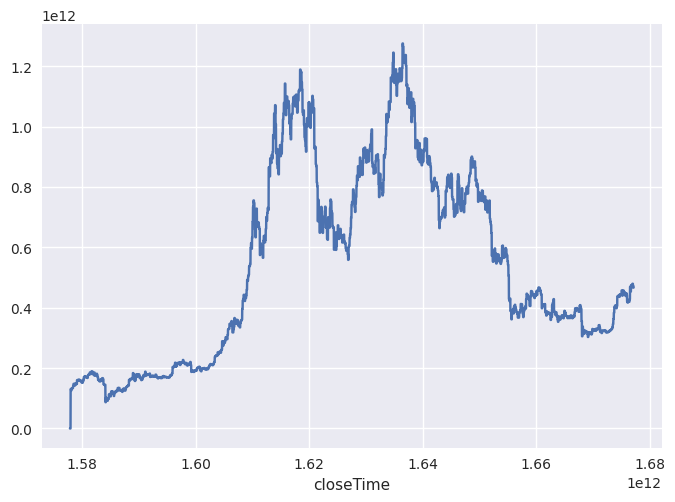

In [163]:
cap['btcusdt'].plot()